In [1]:
import os
import warnings
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from numpy import linalg as LA

from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics

from sklearn.decomposition import PCA

## Q1

In [8]:
# helper functions

# apply a threshold based alarm
def apply_independent_alarm(X, means, stds, epsilon):
    p = 1; # initialize p
    for i in range(0,len(X)):
        p *= stats.norm.pdf(X[i],means[i],stds[i])
    return p < epsilon

# get the probability of a sample
def get_independent_probs(X, means, stds):
    p = 1; # initialize p
    for i in range(0,len(X)):
        p *= stats.norm.pdf(X[i],means[i],stds[i])
    return p

# get the probability of a sample
def get_multivariate_probs(X, means, stds):
    p = 1; # initialize p
    for i in range(0,len(X)):
        p *= stats.norm.pdf(X[i],means[i],stds[i])
    return p

### Independent Gaussian Model

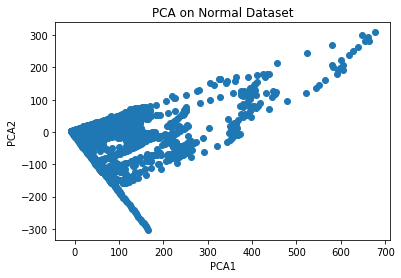

In [25]:
# csv names
file_name_normal = "merged_exp_normal.csv"
file_name_anomalies = "merged_exp_contains_anomalies.csv"

experiment = 'HEAT_ID_01_ALARM_OUT_tag' # experiment to use

# load the normal data
df_normal = pd.read_csv(file_name_normal, index_col = 0)

# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# select only rows from the experiment to use
df_anomaly = df_anomaly[df_anomaly['experiment']==experiment] 

# separate the anomaly tags
true_labels = df_anomaly['Anomaly_Tag']

# select only the columns we care about (keep only the feature vectors)
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
df_normal.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)

# create a PCA transform, keeping only the two most important features
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(df_normal)

# transform the normal features into PCA1 and PCA2 features
x_transform = pca.transform(df_normal)

# plot PCA1 and PCA2
plt.scatter(x_transform[:,0],x_transform[:,1])
plt.title("PCA on Normal Dataset")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

In [26]:
print(true_labels)

745     0
746     0
747     0
748     0
749     0
       ..
3244    0
3245    0
3246    0
3247    0
3248    0
Name: Anomaly_Tag, Length: 2180, dtype: int64


745    0
746    0
747    0
748    0
749    0
Name: Anomaly_Tag, dtype: int64
Epsilon: 0.00024394168740578807


Text(0.5, 1.0, 'ROC')

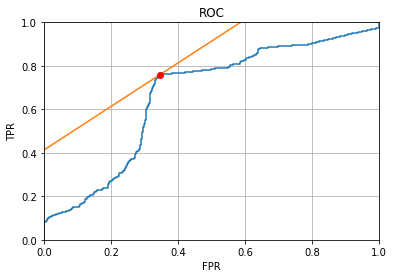

In [60]:
# characterize PCA1 and PCA2 as gaussians
x_pca_means = x_transform.mean(axis=0)
x_pca_std = x_transform.std(axis=0)

# transform the test data into PCA space
x_test = pd.DataFrame(pca.transform(df_anomaly))

epsilon = 0.1

predicted_indepedent_probs = x_test.apply(
    lambda x: get_independent_probs(x, x_pca_means, x_pca_std), axis = 1)

#true_labels = true_labels.apply(lambda x: 0 if (x == 1) else (1))

print(true_labels.head())

# get the ROC curve
fpr,tpr,threshold = roc_curve(true_labels,predicted_indepedent_probs, pos_label = 1)

# the point that maximizes the TPR while minimzing the FPR 
# (assuming equal weight) lies on a line with a slope = 1
# that maximizies the y intercept

intercept = tpr - fpr
i = np.argmax(-intercept)
print("Epsilon: {}".format(threshold[i]))

x = np.linspace(0,1)
plt.plot(tpr,fpr)
plt.plot(1 * x  + intercept[i],x)
plt.plot(tpr[i],fpr[i],'ro')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.title("ROC")

### Multi-variate Gaussian


In [62]:
# csv names
file_name_normal = "merged_exp_normal.csv"
file_name_anomalies = "merged_exp_contains_anomalies.csv"

experiment = 'HEAT_ID_01_ALARM_OUT_tag' # experiment to use

# load the normal data
df_normal = pd.read_csv(file_name_normal, index_col = 0)

# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# select only rows from the experiment to use
df_anomaly = df_anomaly[df_anomaly['experiment']==experiment] 

# separate the anomaly tags
true_labels = df_anomaly['Anomaly_Tag']

# select only the columns we care about (keep only the feature vectors)
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
df_normal.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)

x_multi_means = df_normal.mean()
x_multi_cov = df_normal.cov()

predicted_multi_labels = df_anomaly.apply(
    lambda x: stats.multivariate_normal.pdf(x,
                                            x_multi_means.to_numpy(),
                                            x_multi_cov.to_numpy()),axis=1)

# get the ROC curve
fpr,tpr,threshold = roc_curve(true_labels,predicted_multi_labels, pos_label = 1)

# the point that maximizes the TPR while minimzing the FPR 
# (assuming equal weight) lies on a line with a slope = 1
# that maximizies the y intercept

intercept = tpr - fpr
i = np.argmax(-intercept)
print("Epsilon: {}".format(threshold[i]))

x = np.linspace(0,1)
plt.plot(tpr,fpr)
plt.plot(1 * x  + intercept[i],x)
plt.plot(tpr[i],fpr[i],'ro')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.title("ROC")

Epsilon: 4.145361485697002e-05


Text(0.5, 1.0, 'ROC')

## Q2

In [44]:
# load the normal data
df_normal = pd.read_csv(file_name_normal, index_col = 0)


# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# select only rows from the experiment to use
df_anomaly = df_anomaly[df_anomaly['experiment']==experiment] 

# separate the anomaly tags
true_labels = df_anomaly['Anomaly_Tag']

# select only the columns we care about (keep only the feature vectors)
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
df_normal.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)

# is the data normally distributed?
df_normal.hist(bins=100, figsize=(15,15));

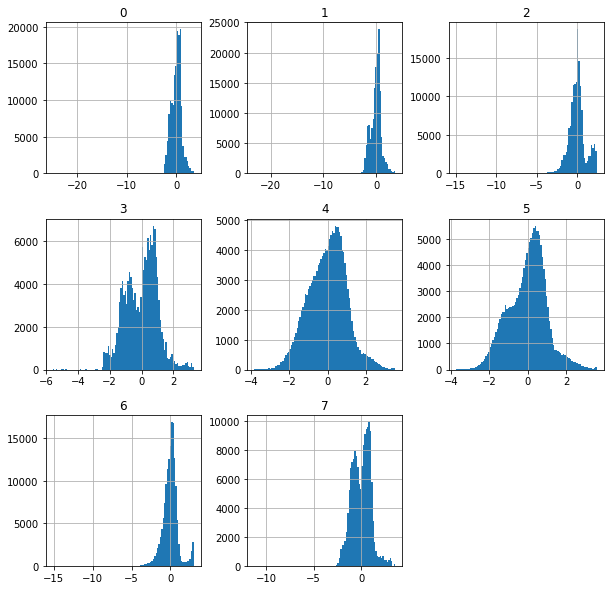

In [45]:
# no.  Use a Box-Cox transform.

from sklearn.preprocessing import PowerTransformer

bc = PowerTransformer(method='box-cox')

bc.fit(df_normal)
x_bc_transform = bc.transform(df_normal)

# is the data normally distributed now?
pd.DataFrame(x_bc_transform).hist(bins=100, figsize=[10,10]);

In [46]:
# it is "more" normal.

# now, apply the two gaussian models from above.

## Box Cox and Independent Gaussian

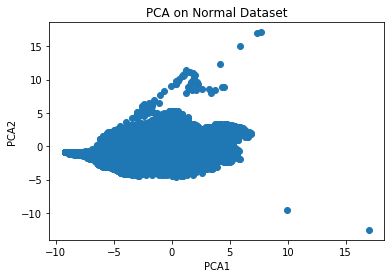

In [47]:
# create a PCA transform, keeping only the two most important features
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(x_bc_transform)

# transform the normal features into PCA1 and PCA2 features
x_bc_pca_transform = pca.transform(x_bc_transform)

# plot PCA1 and PCA2
plt.scatter(x_bc_pca_transform[:,0],x_bc_pca_transform[:,1])
plt.title("PCA on Normal Dataset")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

In [58]:
# characterize PCA1 and PCA2 as gaussians
x_bc_pca_means = x_bc_pca_transform.mean(axis=0)
x_bc_pca_std = x_bc_pca_transform.std(axis=0)

# apply the BC transform and PCA to the test data
x_bc_pca_test = pd.DataFrame(pca.transform(bc.transform(df_anomaly)))

epsilon = 0.1

bc_predicted_indepedent_probs = x_bc_pca_test.apply(
    lambda x: get_independent_probs(x, x_bc_pca_means, x_bc_pca_std), axis = 1)

# get the ROC curve
fpr,tpr,threshold = roc_curve(true_labels,bc_predicted_indepedent_probs, pos_label = 1)

# the point that maximizes the TPR while minimzing the FPR 
# (assuming equal weight) lies on a line with a slope = 1
# that maximizies the y intercept

intercept = tpr - fpr
i = np.argmax(-intercept)
print("Epsilon: {}".format(threshold[i]))

x = np.linspace(0,1)
plt.plot(tpr,fpr)
plt.plot(1 * x  + intercept[i],x)
plt.plot(tpr[i],fpr[i],'ro')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.title("ROC")

Epsilon: 0.012775949918618268


Text(0.5, 1.0, 'ROC')

Epsilon: 1.6498183978662397e-05


Text(0.5, 1.0, 'ROC')

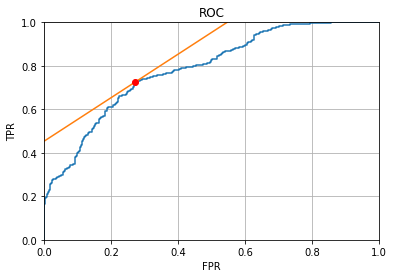

In [57]:
# load the normal data
df_normal = pd.read_csv(file_name_normal, index_col = 0)

# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# select only rows from the experiment to use
df_anomaly = df_anomaly[df_anomaly['experiment']==experiment] 

# separate the anomaly tags
true_labels = df_anomaly['Anomaly_Tag']

# select only the columns we care about (keep only the feature vectors)
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
df_normal.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)

# apply box-cox
bc = PowerTransformer(method='box-cox')

bc.fit(df_normal)
x_bc_transform = pd.DataFrame(bc.transform(df_normal))

# now, fit a multivariate gaussian
x_bc_multi_means = x_bc_transform.mean()
x_bc_multi_cov = x_bc_transform.cov()

df_anomaly_bc = pd.DataFrame(bc.transform(df_anomaly))

predicted_multi_labels = df_anomaly_bc.apply(
    lambda x: stats.multivariate_normal.pdf(x,
                                            x_bc_multi_means.to_numpy(),
                                            x_bc_multi_cov.to_numpy()),axis=1)

# get the ROC curve
fpr,tpr,threshold = roc_curve(true_labels,predicted_multi_labels, pos_label = 1)

# the point that maximizes the TPR while minimzing the FPR 
# (assuming equal weight) lies on a line with a slope = 1
# that maximizies the y intercept

intercept = tpr - fpr
i = np.argmax(-intercept)
print("Epsilon: {}".format(threshold[i]))

x = np.linspace(0,1)
plt.plot(tpr,fpr)
plt.plot(1 * x  + intercept[i],x)
plt.plot(tpr[i],fpr[i],'ro')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
plt.title("ROC")